# Assignment 3
## Sign Language Image Classification using Deep Learning

In this assignment you will implement different deep learning networks to classify images of hands in poses that correspond to letters in American Sign Language. The dataset is contained in the assignment zip file, along with some images and a text file describing the dataset. It is similar in many ways to other MNIST datasets.

The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (**excluding J and Z which require motion**). The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and **no cases for 9=J or 25=Z because of gesture motions**). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, $pixel_{1}$,$pixel_{2}$….$pixel_{784}$ which represent a single 28x28 pixel image with grayscale values between 0-255.

## Scenario

A client is interested in having you (or rather the company that you work for) investigate whether it is possible to develop an app that would enable American sign language to be translated for people that do not sign, or those that sign in different languages/styles. They have provided you with a labelled data of images related to signs (hand positions) that represent individual letters in order to do a preliminary test of feasibility.

Your manager has asked you to do this feasibility assessment, but subject to a constraint on the computational facilities available.  More specifically, you are asked to do **no more than 100 training runs in total** (including all models and hyperparameter settings that you consider).  

The task requires you to create a Jupyter Notebook to perform 22 steps. These steps involve loading the dataset, fixing data problems, converting labels to one-hot encoding, plotting sample images, creating, training, and evaluating two sequential models with 20 Dense layers with 100 neurons each, checking for better accuracy using MC Dropout, retraining the first model with performance scheduling, evaluating both models, using transfer learning to create a new model using pre-trained weights, freezing the weights of the pre-trained layers, adding new Dense layers, training and evaluating the new model, predicting and converting sign language to text using the best model.

### IMPORTANT
* Train all the models locally on your own machine. No model training should occur on Gradescope (GS).
* After completing the training, upload the trained models' **h5 files** and their training histories along with your notebook to GS.
    * best_dnn_bn_model.keras
    * best_dnn_bn_perf_model.keras
    * best_dnn_selu_model.keras
    * best_mobilenet_model.keras
    * history1
    * history2
    * history1_perf
    * historymb
* To avoid any confusion and poor training on GS, please remember to comment out the training code in your notebook before uploading it to GS.


In [2]:
# import the necessary libraries (TensorFlow, sklearn NumPy, Pandas, Matplotlib and cv2)
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
import sklearn
import os
print(os.listdir())
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

['.config', 'sample_data', 'example_letters.jpg', 'challenge1.jpg', 'sign_mnist_train.csv']


**Step0** This test is for checking whether all the required files are submitted. Once you submit all the required files to the autograder, you will be able to pass this step.

**IMPORTANT:** Run this step to determine whether you have created all the required files correctly.

_Points:_ 1

In [1]:
# Don't change this cell code
required_files = ['best_dnn_bn_model.keras','best_dnn_bn_perf_model.keras','best_dnn_selu_model.keras','best_mobilenet_model.keras','history1','history2','history1_perf','historymb']
step0_files = True
for file in required_files:
    if os.path.exists(file) == False:
        step0_files = False
        print("One or more files are missing!")
        break
for file in required_files:
    if not os.path.exists(file):
        print(f"❌ Missing: {file}")
# The following code is used by the autograder. Do not modify it.
step0_data = step0_files



NameError: name 'os' is not defined

In [ ]:
grader.check("step00")

### Data Preprocessing

**STEP1** Load the dataset (train and test) using `Pandas` from the CSV file.

_Points:_ 1

In [4]:
# Load the train and test dataset and store them in train_df and test_df

train_df = pd.read_csv("sign_mnist_train.csv")
test_df = pd.read_csv("sign_mnist_test.csv")

# The following code is used by the autograder. Do not modify it.
step1_sol = test_df.shape


In [ ]:
grader.check("step01")

**STEP2** Examine the data and fix any problems. Make sure it has 24 classes, starting from class 0. In addition, normalize the values of your images in a range of 0 and 1.

_Points:_ 1

In [5]:
train_df = train_df[train_df["label"].isin(range(24))].reset_index(drop=True)
test_df = test_df[test_df["label"].isin(range(24))].reset_index(drop=True)

In [6]:
# Separate labels and pixel values in training and testing sets and assign it to train_labels and train_images
#normalize the values of your images in a range of 0 and 1
train_images = train_df.drop(columns=["label"]).values.astype("float32") / 255.0
train_labels = train_df["label"].values

test_images = test_df.drop(columns=["label"]).values.astype("float32") / 255.0
test_labels = test_df["label"].values

# The following code is used by the autograder. Do not modify it.
step2_sol = {
    "max_label_train": max(train_labels),
    "min_label_train": min(train_labels),
    "max_pixel_value_train": max(train_images.ravel()),
    "min_pixel_value_train": min(train_images.ravel()),
    "max_label_test": max(test_labels),
    "min_label_test": min(test_labels),
    "max_pixel_value_test": max(test_images.ravel()),
    "min_pixel_value_test": min(test_images.ravel())
}


In [ ]:

grader.check("step02")

**STEP3** Convert Labels to One-Hot Encoding both train and test.

_Points:_ 1

In [7]:
#one hot encoding
from tensorflow.keras.utils import to_categorical

label_binarizer = LabelBinarizer()
label_binarizer.fit(range(24))
train_labels_encoded = label_binarizer.transform(train_labels)
test_labels_encoded = label_binarizer.transform(test_labels)


In [8]:
label_binarizer.classes_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [9]:
train_labels_encoded.shape

(26336, 24)

In [10]:
test_labels_encoded.shape

(6840, 24)

In [11]:
# The following code is used by the autograder. Do not modify it.
step3_sol = {
    "train_labels_shape": train_labels_encoded.shape,
    "test_labels_shape": test_labels_encoded.shape,
    "sample_train_label": train_labels_encoded[0],
    "sample_test_label": test_labels_encoded[0]
}



In [ ]:
grader.check("step03")

**STEP4** Plot one sample image for each letter in the dataset given in the training set. To solve this step you should use the function `imshow` to diplay your images in a similar to the image below.

<center><img src="example_letters.jpg" width=400 height=300/></center>





_Points:_ 0

In [ ]:
# Get one sample image for each label
from keras.preprocessing import image
from keras.models import load_model
import tensorflow.keras.layers as tfl

model = load_model("best_dnn_bn_model.keras")
dict = {0: 'A',  1: 'B',  2: 'C',  3: 'D',
    4: 'E',  5: 'F',  6: 'G',  7: 'H',
    8: 'I',  9: 'K', 10: 'L', 11: 'M',
   12: 'N', 13: 'O', 14: 'P', 15: 'Q',
   16: 'R', 17: 'S', 18: 'T', 19: 'U',
   20: 'V', 21: 'W', 22: 'X', 23: 'Y'}

img_path = "example_letters.jpg"
img = image.load_img(img_path, target_size = (28,28))
x = image.img_to_array(img) / 255.0
x = np.expand_dims(x, axis=0)


pred = model.predict(x)
pred_label = np.argmax(pred)
pred_letter = dict[pred_label]


plt.imshow(img, cmap="gray")
plt.title(f"Predicted letter: {predicted_letter}")
plt.axis("off")
plt.show()


# Plot the sample images

grader.check("step04")

## Create Neural Network Architectures

In this part you should create two different models (model1 and model2) with different architectures.

**STEP5**
Create one sequential model in `TensorFlow` with 20 Dense layers with 100 neurons each one. Consider the specific modifications that you need to do in order to work with your specific input and those to get the required output.

* This model uses Batch Normalization after each Dense layer and uses He initialization for all of them. Apply Swish activation following each Batch Normalization.
* The input layer should be able to accept data of shape (784,), which corresponds to the flattened image data. The output layer should produce 24 outputs to correspond to each class.


_Points:_ 5

In [12]:
# import libraries like dense, BatchNormalization, swish, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Input
from tensorflow.keras.activations import swish
from tensorflow.keras.initializers import HeNormal


#flatten the images
#X_train = X_train.reshape(-1,28*28)
#X_test = X_test.reshape(-1,28*28)

# Model 1: with Batch Normalization
model1 = keras.models.Sequential()
model1.add(keras.layers.Input(shape=(784,)))

for _ in range(20):
    model1.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model1.add(keras.layers.BatchNormalization())
    model1.add(keras.layers.Activation("swish"))

model1.add(keras.layers.Dense(24,activation="softmax"))


# The following code is used by the autograder. Do not modify it.
step5_sol = {
    "total_layers": len(model1.layers),
    "output_activation": model1.layers[-1].activation.__name__,
    "first_layer_input_shape": model1.layers[0].input.shape,
    "last_layer_output_units": model1.layers[-1].units,
    "batch_norm_count": sum([1 for layer in model1.layers if isinstance(layer, BatchNormalization)]),
    "swish_activation_count": sum([1 for layer in model1.layers if hasattr(layer, 'activation') and layer.activation == swish]),
}



In [ ]:
grader.check("step05")

**STEP6**
Create a second sequential model in `TensorFlow` . This model should incorporate specific features to promote self-normalization and include regularization:

* Layers and Neurons: Construct the model with 20 Dense layers, each containing 100 neurons.
* Activation and Initialization:
  * Use SELU (Scaled Exponential Linear Unit) activation for each Dense layer to ensure self-normalization.
  * Initialize weights using the LeCun normal initializer in all Dense layers.
* Regularization:
  * Integrate Dropout with a rate of 0.1 after every second Dense layer starting from the second Dense layer to enhance model regularization without breaking self-normalization.
* Input and Output:
  * The input layer should accept flattened images with a dimension of 784 (28x28 images flattened).
  * The output layer should consist of 24 neurons with softmax activation to handle multi-class classification.

_Points:_ 5

In [14]:
# Model 2: with SELU and self-normalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.initializers import lecun_normal


model2 = Sequential()
model2.add(Input(shape=(784,)))

for layer in range(20):
    model2.add(Dense(100, activation='selu', kernel_initializer=lecun_normal()))
    if (layer + 1 ) % 2 == 0:
        model2.add(Dropout(rate=0.1))

model2.add(keras.layers.Dense(24,activation='softmax'))


# The following code is used by the autograder. Do not modify it.
step6_sol = {
    "total_layers": len(model2.layers),
    "dropout_count": sum([1 for layer in model2.layers if isinstance(layer, Dropout)]),
    "selu_count": sum([1 for layer in model2.layers if hasattr(layer, 'activation') and layer.activation.__name__ == 'selu']),
    "first_layer_config": model2.layers[0].get_config(),
    "output_layer_activation": model2.layers[-1].activation.__name__
}



In [ ]:
grader.check("step06")

## Compile the Models

**STEP7**
Compile the both previous models using **Nadam** optimization. Also:

* Set the loss function to categorical cross-entropy.
* Set the metric to accuracy.

_Points:_ 2

In [15]:
# Compile both models
model1.compile(optimizer="Nadam", loss='categorical_crossentropy' , metrics=["accuracy"])
model2.compile(optimizer="Nadam", loss='categorical_crossentropy' , metrics=["accuracy"])

# The following code is used by the autograder. Do not modify it.
step7_sol = {
    "model1_config": {
        "optimizer": str(model1.optimizer.__class__.__name__),
        "loss": model1.loss
    },
    "model2_config": {
        "optimizer": str(model2.optimizer.__class__.__name__),
        "loss": model2.loss,
    }
}




In [ ]:
grader.check("step07")

## Model Training

**STEP8** One of these models work preferably with data, which follow a normal distribution. Generate **train_images_scaled** and **test_images_scaled** using a `Sklearn` function that allow you to convert data to a normal distribution with mean 0 and variance equal 1 and store it in train_images_scaled and test_images_scaled

_Points:_ 2

In [16]:
from sklearn.preprocessing import StandardScaler
X_train_flat = train_images.reshape(-1, 784)
X_test_flat = test_images.reshape(-1, 784)

# Scale to mean 0 and std 1
scaler = StandardScaler()
train_images_scaled = scaler.fit_transform(X_train_flat)
test_images_scaled = scaler.transform(X_test_flat)


# The following code is used by the autograder. Do not modify it.
step8_sol = (np.mean(train_images_scaled),np.mean(test_images_scaled),np.std(train_images_scaled),np.std(test_images_scaled))

In [ ]:
grader.check("step08")

**STEP9** Train the two models on the training dataset using early stopping. In order to save the results given by your training for your models, create checkpoints saving the best model in each case using the function `ModelCheckpoint`. Note that one of the models use the scaled data obtained in **STEP8**. Meanwhile, the other model does not. Figure out which is the proper input data for each model.

* Limit the number of epochs to 100. Set the batch size to or greater than 32.

**IMPORTANT:** Comment out the code to train/fit the two models. Keep the code given to save the models.

_Points:_ 3

In [18]:
import pickle
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# The following line of code is used by the autograder. Do not modify it.
history1, history2 = None, None

# Set a seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model checkpoint callbacks
model1_checkpoint_cb = ModelCheckpoint("best_dnn_bn_model.keras", save_best_only=True, monitor='val_loss', mode='min')
model2_checkpoint_cb = ModelCheckpoint("best_dnn_selu_model.keras", save_best_only=True, monitor='val_loss', mode='min')

keras_callbacks_model1 = [early_stopping, model1_checkpoint_cb]
keras_callbacks_model2 = [early_stopping, model2_checkpoint_cb]

#################################### Perform the training on your machine and then comment out the following section before uploading it to gradescope.
# Make sure your best model is named as follows:
# # Model1 filename = best_dnn_bn_model.keras
# # Model2 filename = best_dnn_selu_model.keras
# #Train model 1 (Comment this out before submission)
# history1 = model1.fit(train_images, train_labels_encoded,
#                       batch_size=32, epochs=100,
#                       validation_split=0.2,
#                       callbacks=keras_callbacks_model1,
#                       verbose=2)

# # # # Train model 2 (scaled data)
# history2 = model2.fit(train_images_scaled, train_labels_encoded,
#                       batch_size=32, epochs=100,
#                       validation_split=0.2,
#                       callbacks=keras_callbacks_model2,
#                       verbose=2)

# # # # #The following code will save your history - don't change it.
# if 'history1' in globals():
#     with open('./history1', 'wb') as file_pi:
#         pickle.dump(history1.history, file_pi)
# if 'history2' in globals():
#     with open('./history2', 'wb') as file_pi:
#         pickle.dump(history2.history, file_pi)
# # ###################################

# The following code is used by the autograder. Do not modify it.
step9_sol = (model1_checkpoint_cb, model2_checkpoint_cb, early_stopping)

Epoch 1/100
659/659 - 34s - 52ms/step - accuracy: 0.3269 - loss: 2.1387 - val_accuracy: 0.2466 - val_loss: 3.1043
Epoch 2/100
659/659 - 4s - 7ms/step - accuracy: 0.6923 - loss: 0.9347 - val_accuracy: 0.2211 - val_loss: 3.2834
Epoch 3/100
659/659 - 5s - 7ms/step - accuracy: 0.8415 - loss: 0.5033 - val_accuracy: 0.4681 - val_loss: 1.9060
Epoch 4/100
659/659 - 6s - 9ms/step - accuracy: 0.8999 - loss: 0.3214 - val_accuracy: 0.5514 - val_loss: 1.7679
Epoch 5/100
659/659 - 5s - 7ms/step - accuracy: 0.9295 - loss: 0.2317 - val_accuracy: 0.7341 - val_loss: 0.9174
Epoch 6/100
659/659 - 5s - 7ms/step - accuracy: 0.9456 - loss: 0.1817 - val_accuracy: 0.4755 - val_loss: 2.5561
Epoch 7/100
659/659 - 4s - 7ms/step - accuracy: 0.9516 - loss: 0.1574 - val_accuracy: 0.3557 - val_loss: 3.9302
Epoch 8/100
659/659 - 5s - 8ms/step - accuracy: 0.9610 - loss: 0.1352 - val_accuracy: 0.5353 - val_loss: 2.1772
Epoch 9/100
659/659 - 5s - 8ms/step - accuracy: 0.9660 - loss: 0.1124 - val_accuracy: 0.5232 - val_los

In [ ]:

grader.check("step09")

**STEP10** After training, you must now evaluate the performance of the two previously saved models using the test datasets. Each model has different data requirements:
* Model 1 should be evaluated using the original test dataset.
* Model 2 should be evaluated using the scaled test dataset.
Load each model from their saved states, then perform the evaluation. To pass this step, both models must achieve a test accuracy greater than 50%.

_Points:_ 2

In [19]:
# Do not change the following 4 lines of code.
# define the file name for the saved model
model1_name = "best_dnn_bn_model.keras"
# load the model
model1 = keras.models.load_model(model1_name)
# define the file name for the saved model
model2_name = "best_dnn_selu_model.keras"
# load the model
model2 = keras.models.load_model(model2_name)
model1.compile(optimizer="nadam", loss="categorical_crossentropy", metrics=["accuracy"])
model2.compile(optimizer="nadam", loss="categorical_crossentropy", metrics=["accuracy"])

# Evaluate the models on the test set
test_loss1, test_acc1 = model1.evaluate(test_images, test_labels_encoded, verbose=0)
test_loss2, test_acc2 = model2.evaluate(test_images_scaled, test_labels_encoded, verbose=0)

print(f"Model 1| Test accuracy: {test_acc1:.4f}, Test loss: {test_loss1:.4f}")
print(f"Model 2| Test accuracy: {test_acc2:.4f}, Test loss: {test_loss2:.4f}")

# The following code is used by the autograder. Do not modify it.
step10_sol = (test_loss1, test_acc1, test_loss2, test_acc2, model1, model2)

Model 1| Test accuracy: 0.5060, Test loss: 2.0385
Model 2| Test accuracy: 0.7930, Test loss: 1.4189


In [ ]:


grader.check("step10")

NameError: name 'grader' is not defined

**STEP11** From the loaded history of the two trained models, plot a graph of **accuracy** vs **number of epochs** for both training and validation.

_Points:_ 0

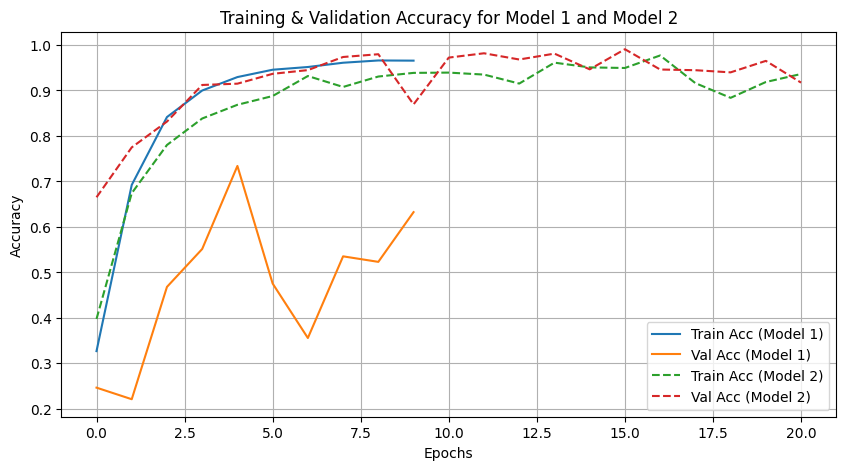

In [20]:
import matplotlib.pyplot as plt

# Load history for model 1 (Do not modify this code)
history_name1 = "./history1"
with open(history_name1, "rb") as file_pi:
    loaded_history1 = pickle.load(file_pi)

# Load history for model 2 (Do not modify this code)
history_name2 = "./history2"
with open(history_name2, "rb") as file_pi:
    loaded_history2 = pickle.load(file_pi)

# --- Plot accuracy for Model 1 ---
plt.figure(figsize=(10,5))
plt.plot(loaded_history1['accuracy'], label='Train Acc (Model 1)')
plt.plot(loaded_history1['val_accuracy'], label='Val Acc (Model 1)')

# Plot training & validation accuracy for model 2
plt.plot(loaded_history2['accuracy'], label='Train Acc (Model 2)', linestyle='--')
plt.plot(loaded_history2['val_accuracy'], label='Val Acc (Model 2)', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy for Model 1 and Model 2')
plt.legend()
plt.grid(True)
plt.show()

# The following code is used by the autograder. Do not modify it.
step11_sol = (loaded_history1, loaded_history2)

In [ ]:
grader.check("step11")

## MC Dropout

**STEP12** Check if model2 achieves better accuracy using MC Dropout (without retraining).

_Points:_ 3

In [ ]:
#This function computes the MC (Monte Carlo) Dropout predictions for a given model and input data.
# It returns the mean of multiple predictions obtained by running the model in training mode.
#Parameters
#   model: A trained model with a dropout layers.
#   X    : The input data for which the predictions are to be made.
#   n_samples: The number of Monte Carlo samples to generate..
#Returns
  # The function returns an array-like object containing the MC Dropout predictions for the given input data.
  # The shape of the output should be the same as the model's output layer.
# The MC Dropout prediction function
def mc_dropout_predict(model, X, n_samples=20):
    predictions = []
    for _ in range(n_samples):
        predictions.append(model(X, training=True))  # Run in training mode to activate Dropout
    predictions = np.array(predictions)
    mean_predictions = predictions.mean(axis=0)
    output_mc = mean_predictions
    return output_mc

# Compute MC Dropout predictions
output_mc = mc_dropout_predict(model2, test_images_scaled, n_samples=20)

# Compute MC Dropout accuracy
accuracy_mc = np.mean(np.argmax(output_mc, axis=1) == np.argmax(test_labels_encoded, axis=1))

# Display result
print(f"Model 2 with MC Dropout: Test accuracy: {accuracy_mc:.4f}")

# The following code is used by the autograder. Do not modify it.
step12_sol = (output_mc, accuracy_mc)


Model 2 with MC Dropout: Test accuracy: 0.7677


In [ ]:
grader.check("step12")

## Learning Rate (LR) scheduling

**STEP13** Retrain model1 using performance scheduling and see if it improves training speed and model accuracy.

**IMPORTANT:** Define the model the same way model1 was defined and compile the model the same way as model1.

_Points:_ 2

In [24]:
# import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Nadam

# Do not modify the following line of code.
history1_perf = None

# Redefine Model 1
model1_perfLRS = keras.models.Sequential([
    keras.layers.Input(shape=[784]),  # use the flattened shape
    keras.layers.Dense(100, activation=None),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dense(100, activation=None),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dense(100, activation=None),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dense(100, activation=None),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dense(24, activation='softmax')
])


model1_perfLRS.compile(optimizer=Nadam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Compile the model with Nadam optimizer and categorical cross-entropy loss


lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Creating model checkpoint to save the best model.
dnn_bn_perf_checkpoint_cb = ModelCheckpoint("best_dnn_bn_perf_model.keras", save_best_only=True, monitor='val_loss', mode='min')

#####Perform the training on your machine and then comment out the following section before uploading it to gradescope.
####################################
# Make sure your best model is named as follows:
# Model1 with performance scheduling filename = best_dnn_bn_perf_model.keras


# # Train the model using early stopping and exponential scheduling (Comment this out before submission)
# history1_perf = model1_perfLRS.fit(
#     train_images,
#     train_labels_encoded,
#     batch_size=32,
#     epochs=100,
#     validation_split=0.2,
#     callbacks=[early_stopping_cb, lr_scheduler, dnn_bn_perf_checkpoint_cb],
#     verbose=2
# )

# # # # # # The following code will save your history - don't change it - comment it out before uploading to GS
# if "history1_perf" in globals():
#     with open('./history1_perf', 'wb') as file_pi:
#         pickle.dump(history1_perf.history, file_pi)
####################################
# The following code is used by the autograder. Do not modify it.
step13_sol = (dnn_bn_perf_checkpoint_cb, lr_scheduler)

Epoch 1/100
659/659 - 10s - 15ms/step - accuracy: 0.7961 - loss: 0.7707 - val_accuracy: 0.4848 - val_loss: 1.6495 - learning_rate: 1.0000e-03
Epoch 2/100
659/659 - 6s - 9ms/step - accuracy: 0.9724 - loss: 0.1067 - val_accuracy: 0.3028 - val_loss: 4.3610 - learning_rate: 1.0000e-03
Epoch 3/100
659/659 - 3s - 5ms/step - accuracy: 0.9878 - loss: 0.0474 - val_accuracy: 0.2658 - val_loss: 4.7710 - learning_rate: 1.0000e-03
Epoch 4/100
659/659 - 5s - 7ms/step - accuracy: 0.9820 - loss: 0.0609 - val_accuracy: 0.3703 - val_loss: 3.5822 - learning_rate: 1.0000e-03
Epoch 5/100
659/659 - 2s - 4ms/step - accuracy: 0.9979 - loss: 0.0111 - val_accuracy: 1.0000 - val_loss: 8.7211e-04 - learning_rate: 5.0000e-04
Epoch 6/100
659/659 - 2s - 3ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 1.4451e-04 - learning_rate: 5.0000e-04
Epoch 7/100
659/659 - 3s - 5ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 9.2345e-05 - learning_rate: 5.0000e-04
Epoch 

In [ ]:
grader.check("step13")

**STEP14** Using the loaded model obtained from the code given below, evaluate the performance of the model on the test set.

_Points:_ 1

In [25]:
# Do not change the following 2 lines of code.
# define the file name for the saved model
model_name = "best_dnn_bn_perf_model.keras"
# load the model
model1_perf = keras.models.load_model(model_name)

# Evaluate the model on the test set and find loss and accuracy
test_loss1_perf, test_acc1_perf = model1_perf.evaluate(test_images, test_labels_encoded, verbose=0)

print(f"Model 1 with LR Scheduler | Test accuracy: {test_acc1_perf:.4f}, Test loss: {test_loss1_perf:.4f}")

# The following code is used by the autograder. Do not modify it.
step14_sol = (test_loss1_perf, test_acc1_perf)

Model 1 with LR Scheduler | Test accuracy: 0.8256, Test loss: 1.0200


In [ ]:
grader.check("step14")

<!-- BEGIN QUESTION -->

**STEP15** From the history of the models loaded using the code given below, plot a graph of **accuracy** vs **number of epochs** for both training and validation.

_Points:_ 0

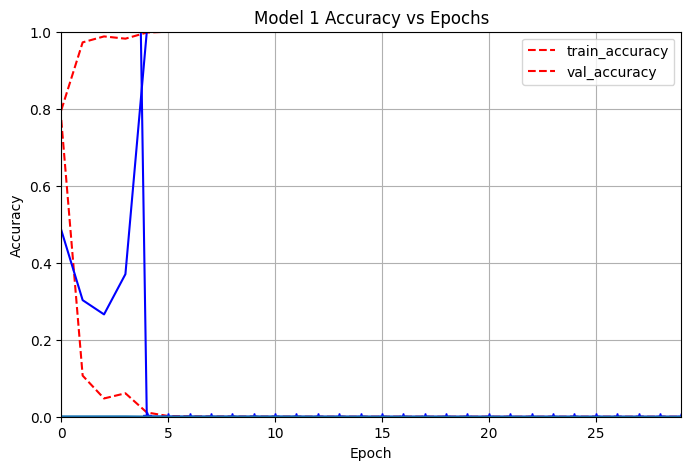

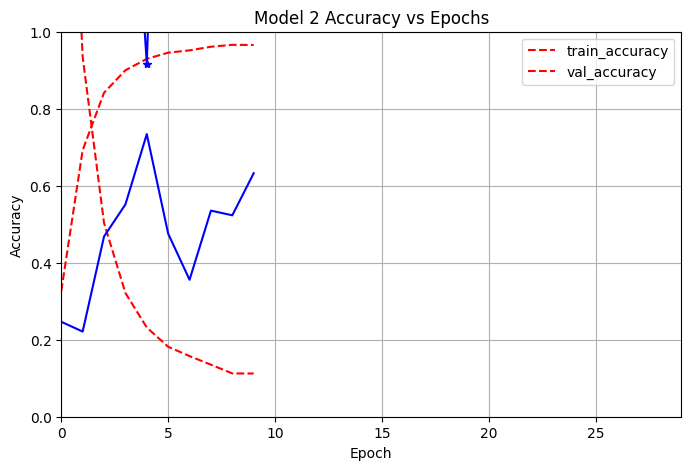

In [26]:
# load history for model 1 with learning rate scheduling (do not modify the following code)
history_name1_perf = "./history1_perf"
with open(history_name1_perf, "rb") as file_pi:
    loaded_history1_perf = pickle.load(file_pi)

# Load history for the original model1 (do not modify the following code)
history_name1 = "./history1"
with open(history_name1, "rb") as file_pi:
    loaded_history1 = pickle.load(file_pi)

# Plot the training and validation accuracy for both models
pd.DataFrame(loaded_history1_perf).plot(
    figsize=(8,5), xlim=[0,29], ylim=[0,1], grid=True, xlabel ="Epoch",ylabel="Accuracy", title="Model 1 Accuracy vs Epochs", style=["r--", "r--", "b-", "b-*"])
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()

pd.DataFrame(loaded_history1).plot(
    figsize=(8,5), xlim=[0,29], ylim=[0,1], grid=True, xlabel ="Epoch", ylabel="Accuracy", title="Model 2 Accuracy vs Epochs",style=["r--", "r--", "b-", "b-*"])
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()

In [ ]:
grader.check("step15")

<!-- END QUESTION -->

## Transfer learning

Use transfer learning by using a pre-trained **MobileNetV3Small** model on imagenet dataset, and fine-tuning it on the Sign Language MNIST dataset.

**STEP16** First of all, you to prepare your data for this model.
* Reshape your input data (train and test) to (28, 28, 3).
* Standardize your input.

_Points:_ 2

In [27]:
train_images_mb = train_images.reshape(-1, 28, 28, 1)
test_images_mb = test_images.reshape(-1, 28, 28, 1)

# Convert grayscale (1 channel) to RGB (3 channels) by repeating the single channel
train_images_mb = np.repeat(train_images_mb, 3, axis=-1)
test_images_mb = np.repeat(test_images_mb, 3, axis=-1)

# Standardize to [-1, 1] range
train_images_mb = (train_images_mb - 0.5) * 2.0
test_images_mb = (test_images_mb - 0.5) * 2.0

# The following code is used by the autograder. Do not modify it.
step16_sol = (train_images_mb,test_images_mb)

In [ ]:
grader.check("step16")

**Step17** Now, we need to define and set up the model. For this you need to follow the next steps:

* Load the pre-trained **MobileNetV3Small** model with weights from ImageNet.
* Modify the model to accept inputs of shape (56, 56, 3).
* Freeze the weights of the pretrained layers.*
* Add input layer that take an image of shape (28,28,3), then a layer `UpSampling2D` to upscale the input by a factor of 2 so they can go through the network.

Consider that maybe you need to adapt the default output.

_Points:_ 2

In [34]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Input, UpSampling2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the pre-trained MobileNet model with weights from ImageNet
base_mb_model = MobileNetV3Small(
    input_shape=(56, 56, 3),
    include_top=False,
    weights='imagenet'
)

base_mb_model.trainable = False

# Create new input layer for (28, 28, 1)
input_layer = Input(shape=(28, 28, 3))
# Upscale to (56, 56, 3)
x = UpSampling2D(size=(2, 2))(input_layer)

# Pass through base model
x = base_mb_model(x, training=False)

# Classification head (improved)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output_layer = Dense(24, activation='softmax')(x)

# Final model
final_mb_model = Model(inputs=input_layer, outputs=output_layer)

# The following code is used by the autograder. Do not modify it.
step17_sol = final_mb_model

In [ ]:
grader.check("step17")

**Step18** Once we define the model and do the specific modifications to adjust to our data, we compile it.

* Use a learning rate schedule that uses an exponential decay schedule.
* Compile and train the model.

_Points:_ 2

In [37]:
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Define an initial learning rate
initial_learning_rate = 0.001

# Create the proper Learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9
)

final_mb_model.compile(
    optimizer=Nadam(learning_rate=lr_schedule),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
# The following code is used by the autograder. Do not modify it.
step18_sol = (lr_schedule, final_mb_model)

In [ ]:
grader.check("step18")

**Step19** Train the mobilenet model. Include early stopping in your training procedure.

_Points:_ 2

In [38]:
# import ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pickle
# Do not modify the following line of code.
history_mb = None
# Define model checkpoint callback (Do not modify this code).
best_model_checkpoint = ModelCheckpoint(
    "best_mobilenet_model.keras",
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

# Set up early stopping
early_stopping_cb = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

## Perform the training on your machine and then comment out the following section before uploading it to gradescope.
####################################
# make sure your best model is named as follow:
# MobileNet model filename = best_mobilenet_model.keras
# Train the model (comment this section out)
# history_mb = final_mb_model.fit(
#     train_images_mb,
#     train_labels_encoded,
#     batch_size=32,
#     epochs=100,
#     validation_split=0.2,
#     callbacks=[early_stopping_cb, best_model_checkpoint],
#     verbose=2
# )

# # # # # The following code will save your history - don't change it
# if "history_mb" in globals():
#     with open('./historymb', 'wb') as file_pi:
#         pickle.dump(history_mb.history, file_pi)
# # ####################################

# The following code is used by the autograder. Do not modify it.
step19_sol = (best_model_checkpoint, early_stopping_cb)

Epoch 1/100
659/659 - 28s - 42ms/step - accuracy: 0.1066 - loss: 2.9795 - val_accuracy: 0.1726 - val_loss: 2.7571
Epoch 2/100
659/659 - 5s - 8ms/step - accuracy: 0.1748 - loss: 2.6534 - val_accuracy: 0.2652 - val_loss: 2.4466
Epoch 3/100
659/659 - 4s - 6ms/step - accuracy: 0.2237 - loss: 2.4315 - val_accuracy: 0.3305 - val_loss: 2.2418
Epoch 4/100
659/659 - 6s - 9ms/step - accuracy: 0.2761 - loss: 2.2569 - val_accuracy: 0.3842 - val_loss: 2.0545
Epoch 5/100
659/659 - 5s - 7ms/step - accuracy: 0.3153 - loss: 2.1133 - val_accuracy: 0.4191 - val_loss: 1.9144
Epoch 6/100
659/659 - 4s - 7ms/step - accuracy: 0.3440 - loss: 2.0044 - val_accuracy: 0.4468 - val_loss: 1.8044
Epoch 7/100
659/659 - 5s - 8ms/step - accuracy: 0.3600 - loss: 1.9251 - val_accuracy: 0.4565 - val_loss: 1.7344
Epoch 8/100
659/659 - 5s - 8ms/step - accuracy: 0.3820 - loss: 1.8571 - val_accuracy: 0.4748 - val_loss: 1.6608
Epoch 9/100
659/659 - 5s - 8ms/step - accuracy: 0.3958 - loss: 1.7900 - val_accuracy: 0.4949 - val_los

In [ ]:
grader.check("step19")

**Step20** For the trained model loaded using the code given below, evaluate its performance on the test set.

_Points:_ 1

In [39]:
# Do not modify the following two lines of code.
# define the file name for the saved model
model_name = "best_mobilenet_model.keras"
# load the model
final_mb_model = keras.models.load_model(model_name)

# Evaluate the model on the test set
test_loss1_mobilenet, test_acc1_mobilenet = final_mb_model.evaluate(test_images_mb, test_labels_encoded, verbose=0)
print(f"Model Mobile Net: Test accuracy: {test_acc1_mobilenet:.4f}")

# The following code is used by the autograder. Do not modify it.
step20_sol = (test_loss1_mobilenet,test_acc1_mobilenet)

Model Mobile Net: Test accuracy: 0.7376


In [ ]:
grader.check("step20")

**Step21** So far, you have seen the overall performance of your models. However, it is possible that some classes may be more difficult to classify than others. To gain a clearer understanding of which letters are the most difficult or easiest to predict, you can use your MobileNet model and make predictions on your test data using the predict function. Based on this, you can check the proportion of correct matches for each letter over the total number of that specific letter in the test data (as the proportion of one letter may differ from that of others). Finally, return the result as a string indicating the most complex and easiest letter to predict based on our analysis (e.g., "a" in lowercase).

_Points:_ 2

In [43]:
# Put here again the labels (not hot encoded)
label_indices = np.argmax(test_labels_encoded, axis=1)
letters = list("abcdefghiklmnopqrstuvxyz")
test_labels = np.array([letters[i] for i in label_indices])
# Make the prediction using MobileNet model. Use the function predict.
prediction_test = final_mb_model.predict(test_images_mb)
predicted_labels = np.argmax(prediction_test, axis=1)

predicted_labels_letters = np.array([letters[i] for i in predicted_labels])

# Calculate per-letter accuracy
letter_accuracies = {}

for letter in letters:
    mask = (test_labels == letter)
    if np.sum(mask) == 0:
        continue  # Avoid division by zero
    correct = np.sum(predicted_labels_letters[mask] == letter)
    accuracy = correct / np.sum(mask)
    letter_accuracies[letter] = accuracy

# Now this won't fail
complex_letter = min(letter_accuracies, key=letter_accuracies.get)
easiest_letter = max(letter_accuracies, key=letter_accuracies.get)

# The following code is used by the autograder. Do not modify it.
step21_sol = (test_labels,prediction_test,complex_letter,easiest_letter)

214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [ ]:
grader.check("step21")

## Using our final model

**Step22**

**Predict on a new sample** Process the image `challenge1.jpg` and try to dechiper what is the letter in the image using your best model. Be aware that your model gives you numeric results, however you should convert this result in a proper output of letters (use lowercase letters).

_Points:_ 2

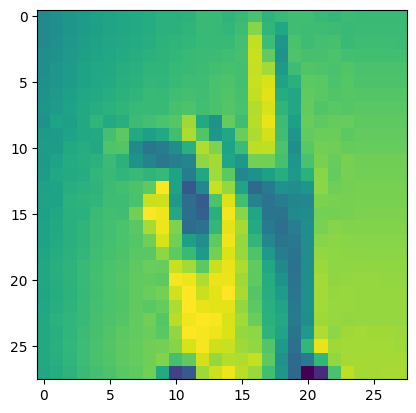

NameError: name 'preprocess_input' is not defined

In [41]:
# Load the image (do not modify this line of code)
img_challenge1 = cv2.imread('challenge1.jpg', cv2.IMREAD_GRAYSCALE)

# Plot the image (do not modify the following 2 lines of code)
plt.imshow(img_challenge1)
plt.show()

# Process the data
img_resized = cv2.resize(img_challenge1, (28, 28))  # Resize to 28x28
img_reshaped = np.expand_dims(img_resized, axis=-1)  # Add channel dimension (28,28,1)
img_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(img_reshaped, dtype=tf.float32))  # Convert to RGB (28,28,3)
img_input = tf.expand_dims(img_rgb, axis=0)  # Add batch dimension (1,28,28,3)
img_input = preprocess_input(img_input)  # Apply MobileNet preprocessing

# Predict in this data using your best model
prediction_challenge1 = final_mb_model.predict(img_input)


# Decoding result. This should be the string representation of the output generated by your model.
label_map = {
    0: 'a', 1: 'b', 2: 'c', 3: 'd',
    4: 'e', 5: 'f', 6: 'g', 7: 'h',
    8: 'i', 9: 'k', 10: 'l', 11: 'm',
    12: 'n', 13: 'o', 14: 'p', 15: 'q',
    16: 'r', 17: 's', 18: 't', 19: 'u',
    20: 'v', 21: 'w', 22: 'x', 23: 'y'
}
predicted_index = np.argmax(prediction_challenge1)
result_challenge1 = label_map[predicted_index]

# The following code is used by the autograder. Do not modify it.
step22_sol = (result_challenge1)